In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.tensor.random.utils import params_broadcast_shapes
from sklearn.preprocessing import MaxAbsScaler
from scipy.stats import pearsonr
import xarray as xr

from utils import delayed_adstock
from plots import plot_posterior
from plots import plot_prior_predictive_samples


In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.2.0


In [3]:
raw = pd.read_csv('MMM_test_data.csv')
df=raw.copy()


In [4]:
spend_channels= ['spend_channel_1','spend_channel_2','spend_channel_3','spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
df['start_of_week'] = pd.to_datetime(df['start_of_week'],format="%d-%m-%y",dayfirst=True)
date_data= df['start_of_week']
channel_data = df[spend_channels]
target_data=df['revenue']
n_obs,n_channels= np.shape(channel_data)

In [5]:
df['day'] = df.start_of_week.dt.dayofyear
n_order = 7
periods = df["day"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

trend = (df.index - df.index.min()) / (df.index.max() - df.index.min())
df['trend'] = trend
seasonality =  fourier_features



In [6]:
target_scaler = MaxAbsScaler()
target_scaler.fit(target_data.values.reshape(-1,1))
target_scaled = pd.Series(target_scaler.transform(target_data.values.reshape(-1,1)).flatten())

channel_scaler = MaxAbsScaler()
channel_scaler.fit(channel_data)
channel_scaled = pd.DataFrame(channel_scaler.transform(channel_data),columns=channel_data.columns)


<Axes: >

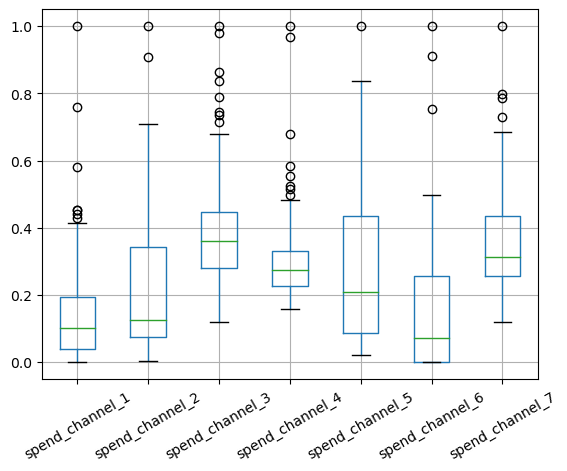

In [7]:
channel_scaled.boxplot( rot=30)

In [8]:
coords={"date": date_data,
        "channel": channel_scaled,
        "seasonality":seasonality,
        "trend":df['trend']}

In [9]:
max_lag=13

with pm.Model(coords=coords) as model:
    #data containers
    channel_data_ = pm.MutableData(
        name="channel_data",
        value=channel_scaled,
        dims=("date", "channel"),
    )
    seasonality_ = pm.MutableData(
        name="seasonality_data", value=seasonality, dims=("date", "seasonality")
    )
    trend_ = pm.MutableData(
        name="t", value=df['trend'], dims=("date")
    )
    
    target_ = pm.MutableData(name="target", value=target_scaled, dims="date")

    #-priors
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=1)
    beta_channel = pm.HalfNormal(
        name="beta_channel", sigma=1, dims="channel"
    )
    alpha = pm.Beta(name="alpha", alpha=3, beta=3, dims="channel")
    theta = pm.Uniform('delay',lower=0,upper=max_lag-1,dims='channel')
    sigma = pm.HalfNormal(name="sigma", sigma=1)
    fourier_control = pm.Laplace(
        name="gamma_control", mu=0, b=1, dims="seasonality"
    )
    # degrees of freedom of the t distribution
    nu = pm.Gamma(name="nu", alpha=15, beta=1)
    
    #model parametrization
    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=delayed_adstock(
            x=channel_data_,
            alpha=alpha,
            theta=theta,
            l_max = max_lag
        ),
        dims=("date", "channel"),
    )

    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock*beta_channel,
        dims=("date", "channel"),
    )
    
    mu_var =  channel_contributions.sum(axis=-1)
    
    trend = pm.Deterministic("trend", intercept + b_trend * trend_, dims="date")
    
    control_contributions = pm.Deterministic(
        name="control_contributions",
        var=seasonality_ * fourier_control,
        dims=("date", "seasonality"),
    )
    
    mu_var += control_contributions.sum(axis=-1)
    mu_var += trend
    mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

    pm.StudentT(
        name="likelihood",
        nu=nu,
        mu=mu,
        sigma=sigma,
        observed=target_,
        dims="date",
    )
    model_prior_predictive = pm.sample_prior_predictive()

Sampling: [alpha, b_trend, beta_channel, delay, gamma_control, intercept, likelihood, nu, sigma]


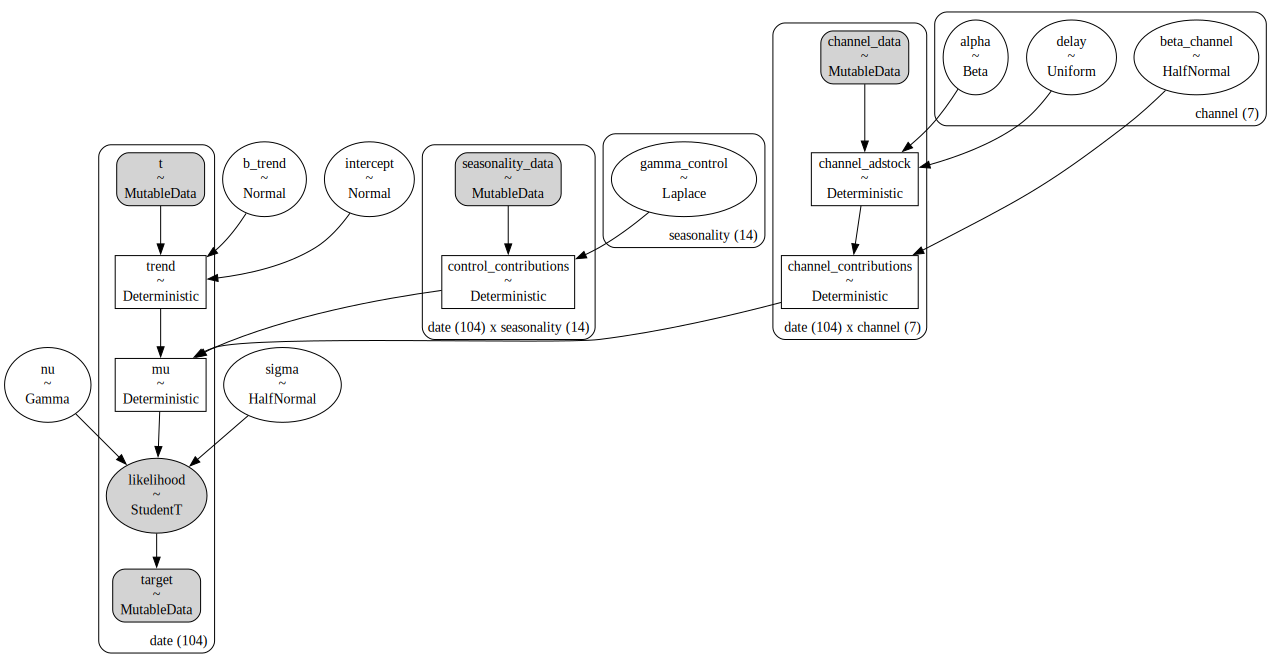

In [10]:
pm.model_to_graphviz(model=model)

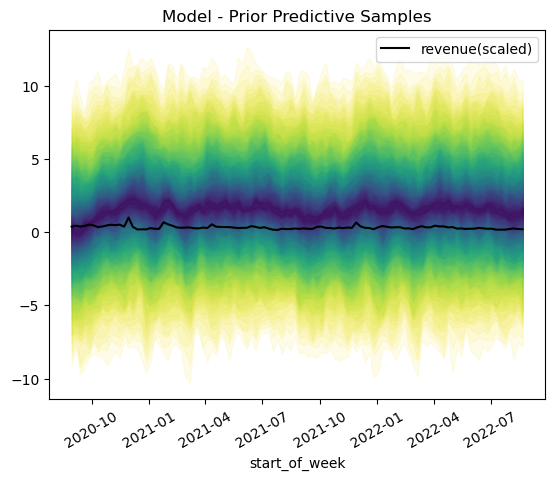

In [11]:
# useful way to color the distribution
plot_settings={
'palette' :"viridis_r",
'cmap' :plt.get_cmap("viridis_r"),
'percs' :np.linspace(51, 99, 100),
'colors' :(np.linspace(51, 99, 100) - np.min(np.linspace(51, 99, 100))) / (np.max(np.linspace(51, 99, 100)) - np.min(np.linspace(51, 99, 100)))}
plot_prior_predictive_samples(model_prior_predictive,target_scaled,date_data,plot_settings)


In [12]:
with model:
    model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive = pm.sample_posterior_predictive(
        trace=model_trace
    )

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)
/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:06.403051
Sampling...


Compiling.. :   0%|                                             | 0/9000 [00:00<?, ?it/s]

  0%|                                                           | 0/9000 [00:00<?, ?it/s]

Compiling.. :   0%|                                             | 0/9000 [00:00<?, ?it/s]


  0%|                                                           | 0/9000 [00:00<?, ?it/s]


Compiling.. :   0%|                                             | 0/9000 [00:00<?, ?it/s]

Running chain 0:   0%|                                          | 0/9000 [00:06<?, ?it/s]


Running chain 0:   5%|█▌                              | 450/9000 [00:13<02:05, 68.24it/s]


Running chain 1:   5%|█▌                              | 450/9000 [00:13<02:11, 65.16it/s]

Running chain 2:   5%|█▌                              | 450/9000 [00:14<02:27, 58.10it/s]


Running chain 1:  10%|███                            | 900/9000 [00:16<01:19, 102.21it/s]

Running chain 2:  10%|███                            | 900/9000 [00:16<01:18, 102.77i

Sampling time =  0:01:08.256699
Transforming variables...
Transformation time =  0:00:03.356549
Computing Log Likelihood...
Log Likelihood time =  0:00:02.971386


Sampling: [likelihood]


In [15]:
az.summary(
    data=model_trace,
    var_names=['alpha','delay','intercept','b_trend','beta_channel','sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
alpha[spend_channel_1]         0.475  0.192   0.132    0.824      0.001   
alpha[spend_channel_2]         0.596  0.188   0.250    0.919      0.001   
alpha[spend_channel_3]         0.449  0.170   0.141    0.767      0.001   
alpha[spend_channel_4]         0.513  0.190   0.174    0.863      0.001   
alpha[spend_channel_5]         0.499  0.188   0.162    0.844      0.001   
alpha[spend_channel_6]         0.554  0.173   0.227    0.852      0.001   
alpha[spend_channel_7]         0.500  0.183   0.171    0.841      0.001   
delay[spend_channel_1]         6.445  2.623   0.961   10.768      0.037   
delay[spend_channel_2]         3.716  2.331   0.001    8.583      0.033   
delay[spend_channel_3]         0.376  0.871   0.000    0.640      0.027   
delay[spend_channel_4]         4.957  3.364   0.000   10.659      0.032   
delay[spend_channel_5]         4.507  3.662   0.000   10.880      0.032   
delay[spend_channel_6]         1.352  0.819   0.059    2.203      0.012   
delay[spend_channel_7]         3.151  1.127   0.128    4.229      0.029   
intercept                      0.013  0.075  -0.130    0.156      0.001   
b_trend                       -0.186  0.081  -0.337   -0.032      0.001   
beta_channel[spend_channel_1]  0.115  0.087   0.000    0.270      0.001   
beta_channel[spend_channel_2]  0.225  0.106   0.030    0.421      0.001   
beta_channel[spend_channel_3]  0.372  0.120   0.145    0.604      0.002   
beta_channel[spend_channel_4]  0.088  0.074   0.000    0.221      0.001   
beta_channel[spend_channel_5]  0.040  0.045   0.000    0.124      0.000   
beta_channel[spend_channel_6]  0.301  0.096   0.116    0.482      0.002   
beta_channel[spend_channel_7]  0.321  0.114   0.104    0.540      0.001   
sigma                          0.057  0.007   0.044    0.071      0.000   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
alpha[spend_channel_1]           0.001   21406.0   20278.0    1.0  
alpha[spend_channel_2]           0.001   19983.0   20614.0    1.0  
alpha[spend_channel_3]           0.001   17211.0   13223.0    1.0  
alpha[spend_channel_4]           0.001   26715.0   22103.0    1.0  
alpha[spend_channel_5]           0.001   26967.0   20609.0    1.0  
alpha[spend_channel_6]           0.001   19850.0   21126.0    1.0  
alpha[spend_channel_7]           0.001   17294.0   16268.0    1.0  
delay[spend_channel_1]           0.026    6812.0   11611.0    1.0  
delay[spend_channel_2]           0.023    5424.0    8155.0    1.0  
delay[spend_channel_3]           0.019    3789.0    1107.0    1.0  
delay[spend_channel_4]           0.023   10626.0   13815.0    1.0  
delay[spend_channel_5]           0.023   14995.0   20727.0    1.0  
delay[spend_channel_6]           0.010    9417.0    8109.0    1.0  
delay[spend_channel_7]           0.020    2559.0    1147.0    1.0  
intercept                        0.001    2986.0    2773.0    1.0  
b_trend                          0.001    7989.0    9103.0    1.0  
beta_channel[spend_channel_1]    0.001    6993.0    9844.0    1.0  
beta_channel[spend_channel_2]    0.001    6598.0    7352.0    1.0  
beta_channel[spend_channel_3]    0.002    2851.0    1980.0    1.0  
beta_channel[spend_channel_4]    0.001   11678.0   12397.0    1.0  
beta_channel[spend_channel_5]    0.000   13316.0   15660.0    1.0  
beta_channel[spend_channel_6]    0.001    3609.0    2803.0    1.0  
beta_channel[spend_channel_7]    0.001    7108.0    5876.0    1.0  
sigma                            0.000   11850.0   18388.0    1.0

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (126), generating only 20 plots
  warnings.warn(


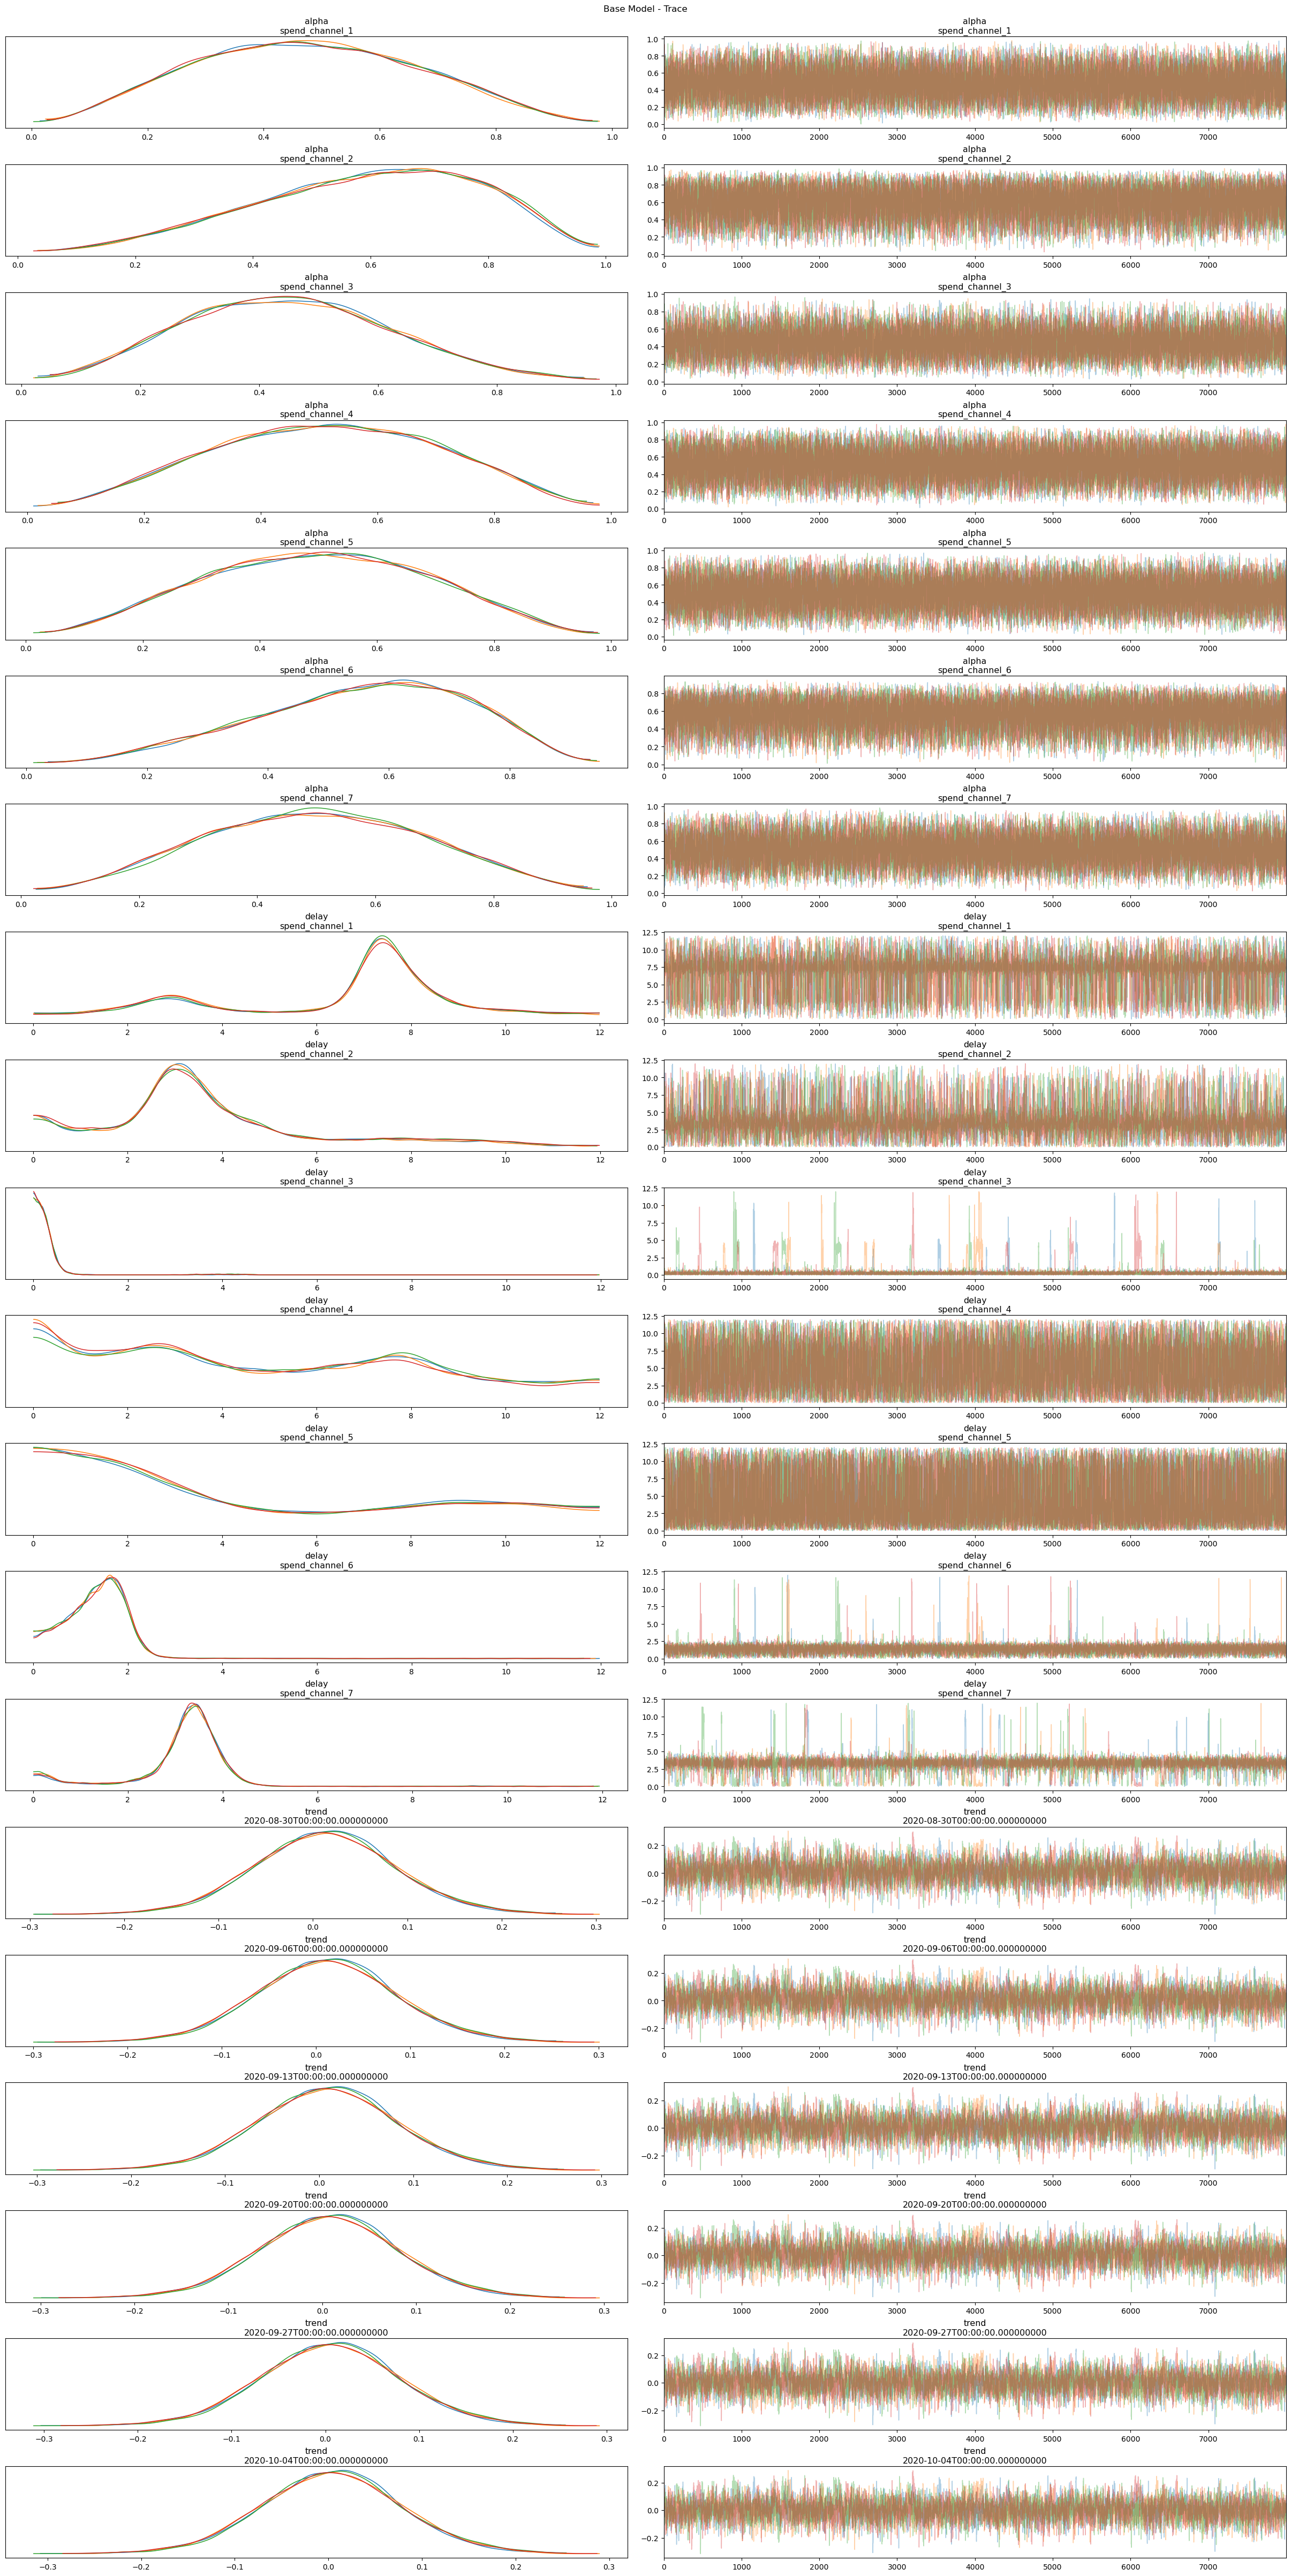

In [20]:
axes = az.plot_trace(
    data=model_trace,
#     var_names=['alpha','delay','intercept','b_trend','beta_channel','nu','gamma_control'],
    var_names=['alpha','delay','trend','beta_channel','sigma'],
    compact=False,
    combined=False,
    backend_kwargs={
        "figsize": (24, 48),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace")
plt.show()

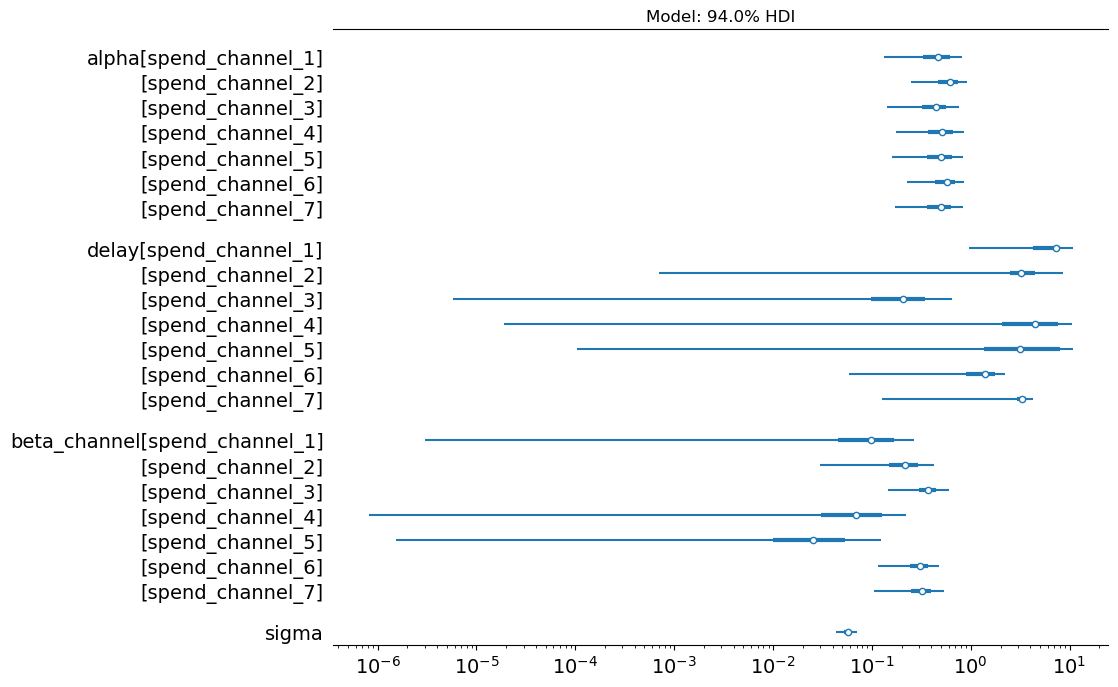

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
az.plot_forest(
    data=model_trace,
    var_names=['alpha','delay','beta_channel','sigma'],
    combined=True,
    ax=ax
)
ax.set(
    title="Model: 94.0% HDI",
    xscale="log"
)
plt.show()

In [ ]:
##Highest Density Interval (HDI) of posterior distributions. 
#All points within this interval have a higher probability density than points 
#outside the interval. The HDI can be used in the context of
#uncertainty characterisation of posterior distributions as Credible Interval (CI).

In [ ]:
## posterior prediction

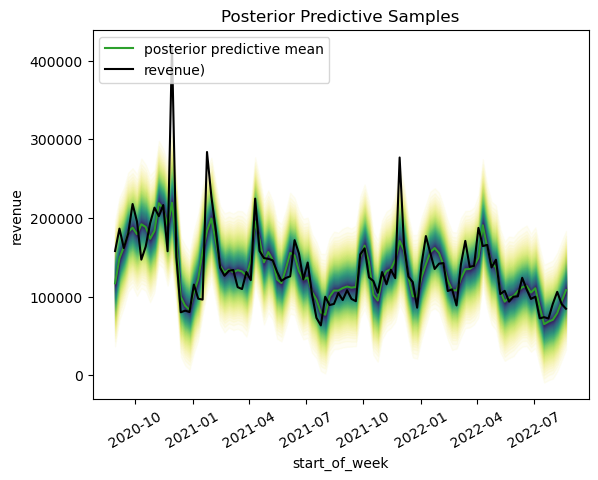

In [23]:
plot_posterior(model_posterior_predictive,date_data,target_data,target_scaler,plot_settings)


not the best 

In [ ]:
model_hdi = az.hdi(ary=model_trace)

fig, ax = plt.subplots()

for i in range(n_channels):
    ax.fill_between(
        x=date_data,
        y1=model_hdi['channel_contributions'][:, i,0],
        y2=model_hdi['channel_contributions'][:, i,1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI ({'channel_contributions'})",
    )
    sns.lineplot(
        x=date_data,
        y=model_trace.posterior['channel_contributions'].stack(sample=("chain", "draw")).mean(axis=2)[:,i]
    )
sns.lineplot(x=date_data, y=target_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax)
plt.show()

In [ ]:
# compute HDI for all the control parameters
fig, ax = plt.subplots()

for i in range(n_channels):
    ax.fill_between(
        x=date_data,
        y1=model_hdi['control_contributions'][:, i,0],
        y2=model_hdi['control_contributions'][:, i,1],
        color=f"C{i}",
        alpha=0.2,
        label=f"$94\%$ HDI ({'control_contributions'})",
    )
    sns.lineplot(
        x=date_data,
        y=model_trace.posterior['control_contributions'].stack(sample=("chain", "draw")).mean(axis=2)[:,i]
    )

ax.fill_between(
    x=date_data,
    y1=model_hdi['trend'][:,0],
    y2=model_hdi['trend'][:,1],
    color=f"C{i}",
    alpha=0.2,
    label=f"$94\%$ HDI ({'trend'})",
)
sns.lineplot(
    x=date_data,
    y=model_trace.posterior['trend'].stack(sample=("chain", "draw")).mean(axis=1)
)
sns.lineplot(x=date_data, y=target_scaled, color="black", alpha=0.8, label="target (scaled)", ax=ax)
plt.show()

try to visualize -> estimated effect of channel spending on revenue.

In [ ]:
#plot it in 1 

channel_contributions_posterior_samples = xr.apply_ufunc(
    lambda x: channel_scaler.inverse_transform(X=x),
    model_trace.posterior["channel_contributions"],
    input_core_dims=[["date","channel"]],
    output_core_dims=[["date","channel"]],
    vectorize=True,
)


channel_effect_hdi = az.hdi(ary=channel_contributions_posterior_samples)["channel_contributions"]

for i in range(n_channels):

    fig, ax = plt.subplots()
    ax.fill_between(
        x=date_data,
        y1=channel_effect_hdi[:,i ,0],
        y2=channel_effect_hdi[:,i ,1],
        color="C0",
        alpha=0.5,
        label="channel_effect_hdi 94% HDI",
    )
    sns.lineplot(
        x=date_data,
        y=channel_contributions_posterior_samples.stack(sample=("chain", "draw")).mean(axis=2)[:,i],
        linestyle="--",
    )
ax.legend(loc="upper right")
ax.set(title="Media Cost Effect on Sales Estimation - Base Model")
plt.show()

In [ ]:
model_hdi = az.hdi(ary=model_trace)

fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(12, 9), sharex=True, sharey=False, layout="constrained"
)

for i, var_name in enumerate(['channel_data','channel_adstock','channel_contributions']):

    var_name_posterior = channel_scaler.inverse_transform(
            X=az.extract(data=model_trace, group="posterior", var_names=var_name)
        )
    var_name_hdi =az.hdi(ary=var_name_posterior.T)

    ax = axes[i + 1]
    sns.lineplot(
        x=date,
        y=var_name_posterior.mean(axis=1),
        color=f"C{i}",
        ax=ax,
    )
    ax.fill_between(
        x=date,
        y1=var_name_hdi[:, 0],
        y2=var_name_hdi[:, 1],
        color=f"C{i}",
        alpha=0.5,
    )
    ax.set(title=var_name)

In [ ]:
#check correalation Note that there seems to be a weak negative correlation between these two parameters!
corr, _ = pearsonr(
    x=asdr_model_trace.posterior["alpha"].stack(sample=("chain", "draw")).to_numpy(),
    y=asdr_model_trace.posterior["lam"].stack(sample=("chain", "draw")).to_numpy()
)

In [ ]:
#ROAS
# return on investment metrics.: ROAS (Return on Ad Spend) and mROAS (marginal ROAS)
# this should be per channel!! change that

In [ ]:
from utils import roas
from utils import mroas
roas(model_trace,model,channel_data,target_scaler,model_posterior_predictive,df,spend_channels)
   

mROAS for the m-th medium is the additional revenue generated by one-unit increase in spend, usually from the current spent level.

Let’s compute the true mROAS. We first need to estimate the effect of z on y by increasing it by 10 and then pushing it through the data transformations using the true values of the parameters (see the blog post (Media Effect Estimation with Orbit’s KTR Model)[https://juanitorduz.github.io/orbit_mmm/] to see the data generation process). Then we subtract the initial effect (again, note that this just works for additive models!)

In [ ]:
mroas(model_trace,model,channel_scaled,target_scaler,model_posterior_predictive,df,spend_channels)

In [ ]:
# 2nd model
max_lag=13

with pm.Model(coords=coords) as model_normal:
    #data containers
    channel_data_ = pm.MutableData(
        name="channel_data",
        value=channel_scaled,
        dims=("date", "channel"),
    )
    seasonality_ = pm.MutableData(
        name="seasonality_data", value=seasonality, dims=("date", "seasonality")
    )
    trend_ = pm.MutableData(
        name="t", value=df['trend'], dims=("date")
    )
    
    target_ = pm.MutableData(name="target", value=target_scaled, dims="date")

    #-priors
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    b_trend = pm.Normal(name="b_trend", mu=0, sigma=1)
    beta_channel = pm.HalfNormal(
        name="beta_channel", sigma=1, dims="channel"
    )
    alpha = pm.Beta(name="alpha", alpha=3, beta=3, dims="channel")
    theta = pm.Uniform('delay',lower=0,upper=max_lag,dims='channel')
    sigma = pm.HalfNormal(name="sigma", sigma=1)
    fourier_control = pm.Laplace(
        name="gamma_control", mu=0, b=1, dims="seasonality"
    )
    #model parametrization
    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=delayed_adstock(
            x=channel_data_,
            alpha=alpha,
            theta=theta,
            l_max = max_lag
        ),
        dims=("date", "channel"),
    )

    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock*beta_channel,
        dims=("date", "channel"),
    )
    
    mu_var =  channel_contributions.sum(axis=-1)
    
    trend = pm.Deterministic("trend", intercept + b_trend * trend_, dims="date")
    
    control_contributions = pm.Deterministic(
        name="control_contributions",
        var=seasonality_ * fourier_control,
        dims=("date", "seasonality"),
    )
    
    mu_var += control_contributions.sum(axis=-1)
    mu_var += trend
    mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

    pm.Normal(
                name="likelihood",
                mu=mu,
                sigma=sigma,
                observed=target_,
                dims="date",
            )
    model_prior_predictive_normal = pm.sample_prior_predictive()

In [ ]:
pm.model_to_graphviz(model=model_normal)

In [ ]:
with model_normal:
    model_trace_normal = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive = pm.sample_posterior_predictive(
        trace=model_trace_normal
    )

In [ ]:
plot_prior_predictive_samples(model_prior_predictive_normal,target_scaled,date_data,plot_settings)


In [ ]:
dataset_dict = {
    "base_model": model_trace,
    "base_model_normal": model_trace_normal,
}
df_comp = az.compare(compare_dict=dataset_dict, ic="loo", method="stacking", scale="log")

In [ ]:
posterior_predictive_likelihood = az.extract(
    data=model_posterior_predictive,
    group="posterior_predictive",
    var_names="likelihood",
)

posterior_predictive_likelihood_inv = target_scaler.inverse_transform(
    X=posterior_predictive_likelihood
)

In [ ]:
az.r2_score(target_data,posterior_predictive_likelihood_inv.mean(axis=1))

In [ ]:
az.summary()

In [ ]:
df_comp 

In [ ]:
az.plot_compare(df_comp, insample_dev=False)
plt.show()

In [ ]:
axes = az.plot_forest(
    data=[model_trace, model_trace_normal],
    model_names=["base_model", "model_normal"],
    var_names=['alpha','delay','sigma'],
    combined=True,
    figsize=(10, 7),
)
plt.show()